In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("D:/dataset/cleaned_improved_cicids2017.csv")

In [4]:
df['Label']

0            BENIGN
1            BENIGN
2            BENIGN
3            BENIGN
4            BENIGN
             ...   
2099966    Portscan
2099967    Portscan
2099968    Portscan
2099969      BENIGN
2099970      BENIGN
Name: Label, Length: 2099971, dtype: object

In [5]:
# 이진분류
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

# 변경된 데이터프레임 확인
print(df.head())

   Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0         0      119719148               231                  0   
1        17       65511209                 6                  6   
2        17      113976922               267                  0   
3        17       67037196                 8                  8   
4        17       68045057                 8                  8   

   Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                           0                           0   
1                         288                         288   
2                       20447                           0   
3                         384                         384   
4                         384                         384   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                      0                      0                0.000000   
1                     48                     48               48.000000   
2    

In [6]:
from sklearn.preprocessing import StandardScaler

tmp = df.drop(labels = 'Label',axis=1)
labels = df['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(tmp)

X_scaled_df = pd.DataFrame(X_scaled, columns=tmp.columns)  # 스케일된 데이터를 DataFrame으로 변환
df_merged = pd.concat([X_scaled_df, labels.reset_index(drop=True)], axis=1)  # Index 정렬 후 병합

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df_merged, test_size=0.1, random_state=42)
X_train.shape, X_test.shape

((1889973, 83), (209998, 83))

In [8]:
df['Label'].value_counts()

0    1594540
1     505431
Name: Label, dtype: int64

In [9]:
X_train_normal = X_train[X_train['Label'] == 0]
X_train_normal.shape

X_test_normal = X_test[X_test['Label'] == 0]
X_test_normal.shape

(159227, 83)

In [10]:
X_train_not_normal = X_train[X_train['Label'] !=0]

X_test = pd.concat([X_test, X_train_not_normal])

In [11]:
y_test = X_test['Label']
X_test = X_test.drop(labels='Label',axis=1)
y_train_normal = X_train_normal['Label']
X_train_normal = X_train_normal.drop(labels='Label', axis=1)

In [12]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Conv1D, Conv1DTranspose
from keras.models import Model
from keras import regularizers
from keras_self_attention import SeqWeightedAttention, SeqSelfAttention
from keras.callbacks import EarlyStopping

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K

latent_dim = 10
inter_dim = 20

# Sampling function for reparameterization trick
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + z_log_sigma * epsilon

def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=1)
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    kl_loss_weighted = kl_loss * 0.001  # KL 다이버전스 손실에 가중치 부여
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    return total_loss

def cvae(X, labels):
    features = X.shape[1]  # 2D 데이터이므로 timesteps는 필요 없고, features만 사용
    input_x = Input(shape=(features,), name='InputFeatures')  # 2D 입력 (샘플, 특징)

    input_label = Input(shape=(1,), name='InputLabel')  # Assumes binary or multi-class label

    # Embed the label into the same shape as the input
    embedded_label = layers.Embedding(input_dim=2, output_dim=features)(input_label)  # Adjust output_dim to match features
    embedded_label = layers.Flatten()(embedded_label)

    # Concatenate input_x and embedded_label
    concatenated_input = layers.Concatenate()([input_x, embedded_label])

    # Reshape for Conv1D layer (to 3D)
    reshaped_input = layers.Reshape((features + embedded_label.shape[-1], 1))(concatenated_input)

    # Encoder with CNN layers
    h = layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding='same')(reshaped_input)
    h = layers.Conv1D(filters=32, kernel_size=3, activation="relu", padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation="relu", padding='same')(h)

    # Flatten for dense layers (MLP)
    h = layers.Flatten()(h)
    h = layers.Dense(inter_dim, activation='relu')(h)
    h = layers.Dense(inter_dim, activation='relu')(h)

    # z layer
    z_mean = layers.Dense(latent_dim)(h)
    z_log_sigma = layers.Dense(latent_dim)(h)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])

    # Decoder
    # Add the label to the latent space z
    z_with_label = layers.Concatenate()([z, embedded_label])

    # Expand for Conv1DTranspose layer
    decoder1 = layers.Dense((features + embedded_label.shape[-1]) * inter_dim)(z_with_label)
    decoder1 = layers.Reshape((features + embedded_label.shape[-1], inter_dim))(decoder1)

    # Decoder with CNN layers
    decoder1 = layers.Conv1DTranspose(filters=16, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=32, kernel_size=3, activation="relu", padding='same')(decoder1)
    decoder1 = layers.Conv1DTranspose(filters=64, kernel_size=3, activation="relu", padding='same')(decoder1)

    # Flatten and final dense layer to reconstruct original features
    decoder1 = layers.Flatten()(decoder1)
    decoder1 = layers.Dense(features)(decoder1)
    
    model = Model([input_x, input_label], decoder1)
    model.add_loss(vae_loss(input_x, decoder1, z_mean, z_log_sigma))
    
    return model

# CVAE 모델 생성
cvae_model = cvae(X_train_normal, y_train_normal)

# 모델 컴파일
cvae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

# EarlyStopping 콜백 설정
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
cvae_model.fit(
    [X_train_normal, y_train_normal], X_train_normal, 
    epochs=50, 
    validation_split=0.1,  
    batch_size=32, 
    shuffle=True, 
    callbacks=[early_stopping]
)


Epoch 1/50
40369/40369 [==============================] - 315s 8ms/step - loss: 106509344768.0000 - accuracy: 0.8316 - val_loss: 13.8551 - val_accuracy: 0.7916
Epoch 2/50
40369/40369 [==============================] - 311s 8ms/step - loss: 70.6949 - accuracy: 0.8776 - val_loss: 5.7024 - val_accuracy: 0.7976
Epoch 3/50
40369/40369 [==============================] - 312s 8ms/step - loss: 14.8913 - accuracy: 0.8756 - val_loss: 5.5567 - val_accuracy: 0.9100
Epoch 4/50
40369/40369 [==============================] - 309s 8ms/step - loss: 78.8099 - accuracy: 0.8757 - val_loss: 4.1688 - val_accuracy: 0.9181
Epoch 5/50
40369/40369 [==============================] - 310s 8ms/step - loss: 9.0670 - accuracy: 0.8832 - val_loss: 3.2387 - val_accuracy: 0.9090
Epoch 6/50
40369/40369 [==============================] - 311s 8ms/step - loss: 7.9029 - accuracy: 0.8946 - val_loss: 1.9776 - val_accuracy: 0.9335
Epoch 7/50
40369/40369 [==============================] - 312s 8ms/step - loss: 6.7277 - accuracy

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Model, Input
import numpy as np
from tensorflow.keras import backend as K

latent_dim = 10
inter_dim = 20

# Sampling function
def sampling(args):
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon  # 수정된 부분

# VAE 손실 함수
def vae_loss(x, x_decoded_mean, z_mean, z_log_sigma):
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean), axis=[1, 2])  
    kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)  
    kl_loss_weighted = kl_loss * 0.0001  
    total_loss = K.mean(reconstruction_loss + kl_loss_weighted)
    return total_loss

# VAE 모델
def vae(X_train):
    features = X_train.shape[1]  
    input_x = Input(shape=(features, 1), name='InputFeatures')  

    h = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_x)
    h = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(h)
    h = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(h)
    h = layers.Flatten()(h)
    h = layers.Dense(inter_dim, activation='relu')(h)

    z_mean = layers.Dense(latent_dim)(h)
    z_log_sigma = layers.Dense(latent_dim)(h)
    z = layers.Lambda(sampling)([z_mean, z_log_sigma])

    decoder = layers.Dense(inter_dim, activation='relu')(z)
    decoder = layers.Dense(features * 16, activation='relu')(decoder)
    decoder = layers.Reshape((features, 16))(decoder)
    decoder = layers.Conv1DTranspose(filters=16, kernel_size=3, activation='relu', padding='same')(decoder)
    decoder = layers.Conv1DTranspose(filters=32, kernel_size=3, activation='relu', padding='same')(decoder)
    decoder = layers.Conv1DTranspose(filters=64, kernel_size=3, activation='relu', padding='same')(decoder)
    decoder = layers.Conv1DTranspose(filters=1, kernel_size=3, activation='linear', padding='same')(decoder)

    model = Model(input_x, decoder)
    model.add_loss(vae_loss(input_x, decoder, z_mean, z_log_sigma))  

    return model



# 데이터 로딩 및 모델 학습
X_train_vae = np.expand_dims(X_train_normal, axis=-1)
vae_model = vae(X_train_vae)
vae_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
vae_model.fit(X_train_vae, X_train_vae, epochs=50, validation_split=0.1, batch_size=32)



Epoch 1/50
40369/40369 [==============================] - 208s 5ms/step - loss: 18.4378 - val_loss: 6.0374
Epoch 2/50
40369/40369 [==============================] - 207s 5ms/step - loss: 8.7067 - val_loss: 5.2538
Epoch 3/50
40369/40369 [==============================] - 207s 5ms/step - loss: 6.9499 - val_loss: 2.5116
Epoch 4/50
40369/40369 [==============================] - 207s 5ms/step - loss: 6.5806 - val_loss: 3.8661
Epoch 5/50
40369/40369 [==============================] - 206s 5ms/step - loss: 5.5249 - val_loss: 1.8923
Epoch 6/50
40369/40369 [==============================] - 208s 5ms/step - loss: 5.6765 - val_loss: 2.0101
Epoch 7/50
40369/40369 [==============================] - 207s 5ms/step - loss: 5.2214 - val_loss: 1.2021
Epoch 8/50
40369/40369 [==============================] - 208s 5ms/step - loss: 4.4482 - val_loss: 1.5453
Epoch 9/50
40369/40369 [==============================] - 205s 5ms/step - loss: 4.5823 - val_loss: 1.5253
Epoch 10/50
40369/40369 [====================

In [30]:
print([layer.name for layer in vae_model.layers])  # 모든 레이어 이름 출력


['InputFeatures', 'conv1d_6', 'conv1d_7', 'conv1d_8', 'flatten_4', 'dense_11', 'dense_12', 'dense_13', 'lambda_2', 'dense_14', 'dense_15', 'reshape_3', 'conv1d_transpose_7', 'conv1d_transpose_8', 'conv1d_transpose_9', 'conv1d_transpose_10', 'tf.__operators__.add_4', 'tf.math.square_5', 'tf.math.subtract_7', 'tf.math.exp_2', 'tf.math.subtract_8', 'tf.math.subtract_6', 'tf.math.reduce_sum_5', 'tf.math.square_4', 'tf.math.multiply_4', 'tf.math.reduce_sum_4', 'tf.math.multiply_5', 'tf.__operators__.add_5', 'tf.math.reduce_mean_2', 'add_loss_2']


In [31]:
encoder_vae = tf.keras.Model(vae_model.input, vae_model.get_layer("lambda_2").output)


In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

# Sampling function (VAE 및 CVAE에서 사용)
def sampling(z_mean, z_log_sigma):
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.)  # z_mean과 동일한 shape
    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

# 🔹 VAE에서 latent space 벡터 추출
print([layer.name for layer in vae_model.layers])  # 레이어 이름 확인
vae_model.summary()  # 모델 구조 확인 (latent_dim 맞는지 체크)

# VAE에서 올바른 레이어 찾기
z_mean_layer_vae = vae_model.get_layer("dense_12")  # 올바른 z_mean 레이어 사용
z_log_sigma_layer_vae = vae_model.get_layer("dense_13")  # 올바른 z_log_sigma 레이어 사용

encoder_vae = tf.keras.Model(vae_model.input, [z_mean_layer_vae.output, z_log_sigma_layer_vae.output])

# 예측 수행
z_mean_vae, z_log_sigma_vae = encoder_vae.predict(X_train_vae)

# Shape 확인 (디버깅)
print(f"z_mean_vae shape: {z_mean_vae.shape}")  # (batch_size, latent_dim) 이어야 함
print(f"z_log_sigma_vae shape: {z_log_sigma_vae.shape}")  # (batch_size, latent_dim) 이어야 함

# 🔹 Shape 맞추기 (broadcasting 문제 해결)
if z_mean_vae.shape[-1] != z_log_sigma_vae.shape[-1]:
    min_dim = min(z_mean_vae.shape[-1], z_log_sigma_vae.shape[-1])
    z_mean_vae = z_mean_vae[:, :min_dim]
    z_log_sigma_vae = z_log_sigma_vae[:, :min_dim]

# 샘플링된 z_vae 생성
z_vae = sampling(z_mean_vae, z_log_sigma_vae).numpy()

# 🔹 CVAE에서 latent space 벡터 추출
print([layer.name for layer in cvae_model.layers])  # CVAE 레이어 이름 확인
cvae_model.summary()  # CVAE 모델 구조 확인

# CVAE에서 올바른 레이어 찾기
z_mean_layer_cvae = cvae_model.get_layer("dense_1")  # 올바른 z_mean 레이어 사용
z_log_sigma_layer_cvae = cvae_model.get_layer("dense_2")  # 올바른 z_log_sigma 레이어 사용

encoder_cvae = tf.keras.Model([cvae_model.input[0], cvae_model.input[1]], 
                              [z_mean_layer_cvae.output, z_log_sigma_layer_cvae.output])

# 예측 수행
z_mean_cvae, z_log_sigma_cvae = encoder_cvae.predict([X_train_normal, y_train_normal])

# Shape 확인 (디버깅)
print(f"z_mean_cvae shape: {z_mean_cvae.shape}")
print(f"z_log_sigma_cvae shape: {z_log_sigma_cvae.shape}")

# 🔹 Shape 맞추기 (broadcasting 문제 해결)
if z_mean_cvae.shape[-1] != z_log_sigma_cvae.shape[-1]:
    min_dim = min(z_mean_cvae.shape[-1], z_log_sigma_cvae.shape[-1])
    z_mean_cvae = z_mean_cvae[:, :min_dim]
    z_log_sigma_cvae = z_log_sigma_cvae[:, :min_dim]

# 샘플링된 z_cvae 생성
z_cvae = sampling(z_mean_cvae, z_log_sigma_cvae).numpy()

# 결과 출력
print(f"z_vae shape: {z_vae.shape}")  # (batch_size, latent_dim)
print(f"z_cvae shape: {z_cvae.shape}")  # (batch_size, latent_dim)


['InputFeatures', 'conv1d_6', 'conv1d_7', 'conv1d_8', 'flatten_4', 'dense_11', 'dense_12', 'dense_13', 'lambda_2', 'dense_14', 'dense_15', 'reshape_3', 'conv1d_transpose_7', 'conv1d_transpose_8', 'conv1d_transpose_9', 'conv1d_transpose_10', 'tf.__operators__.add_4', 'tf.math.square_5', 'tf.math.subtract_7', 'tf.math.exp_2', 'tf.math.subtract_8', 'tf.math.subtract_6', 'tf.math.reduce_sum_5', 'tf.math.square_4', 'tf.math.multiply_4', 'tf.math.reduce_sum_4', 'tf.math.multiply_5', 'tf.__operators__.add_5', 'tf.math.reduce_mean_2', 'add_loss_2']
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InputFeatures (InputLayer)     [(None, 82, 1)]      0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 8

Total params: 71,189
Trainable params: 71,189
Non-trainable params: 0
__________________________________________________________________________________________________
44854/44854 [==============================] - 39s 867us/step
z_mean_vae shape: (1435313, 10)
z_log_sigma_vae shape: (1435313, 10)
['InputLabel', 'embedding', 'InputFeatures', 'flatten', 'concatenate', 'reshape', 'conv1d', 'conv1d_1', 'conv1d_2', 'flatten_1', 'dense', 'dense_1', 'dense_2', 'dense_3', 'lambda', 'concatenate_1', 'dense_4', 'reshape_1', 'conv1d_transpose', 'conv1d_transpose_1', 'conv1d_transpose_2', 'flatten_2', 'dense_5', 'tf.__operators__.add', 'tf.math.square_1', 'tf.math.subtract_1', 'tf.math.exp', 'tf.math.subtract_2', 'tf.math.subtract', 'tf.math.reduce_sum_1', 'tf.math.square', 'tf.math.multiply', 'tf.math.reduce_sum', 'tf.math.multiply_1', 'tf.__operators__.add_1', 'tf.math.reduce_mean', 'add_loss']
Model: "model"
_____________________________________________________________________________________

                                                                                                  
 tf.math.square (TFOpLambda)    (None, 82)           0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None,)              0           ['tf.math.reduce_sum_1[0][0]']   
                                                                                                  
 tf.math.reduce_sum (TFOpLambda  (None,)             0           ['tf.math.square[0][0]']         
 )                                                                                                
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None,)             0           ['tf.math.multiply[0][0]']       
 )                                                                                                
          

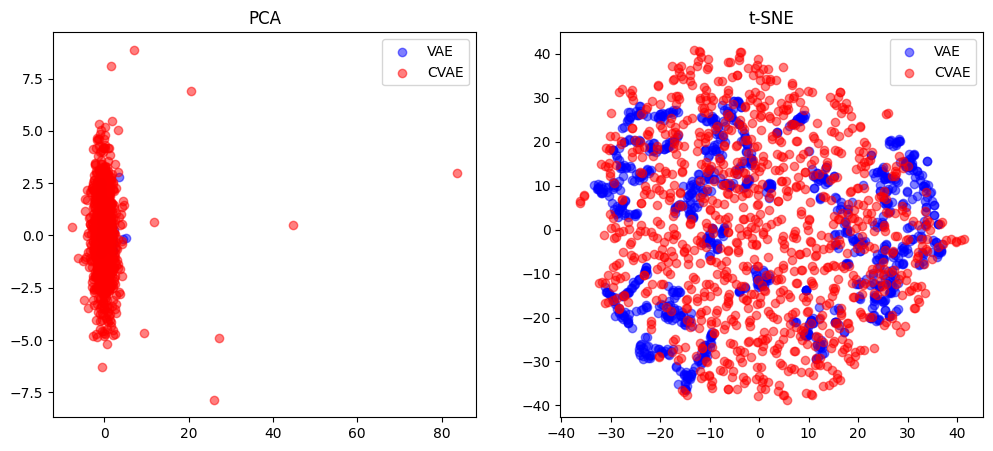

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 샘플링 (속도 개선)
num_samples = 1000
indices = np.random.choice(len(z_vae), num_samples, replace=False)
z_vae_sampled = z_vae[indices]
z_cvae_sampled = z_cvae[indices]

# PCA 변환
pca_vae = PCA(n_components=2).fit_transform(z_vae_sampled)
pca_cvae = PCA(n_components=2).fit_transform(z_cvae_sampled)

# t-SNE 변환
tsne_vae = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42).fit_transform(z_vae_sampled)
tsne_cvae = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42).fit_transform(z_cvae_sampled)

# 시각화 (UMAP 없이 PCA + t-SNE만 사용)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# PCA 시각화
axs[0].scatter(pca_vae[:, 0], pca_vae[:, 1], alpha=0.5, label="VAE", color='blue')
axs[0].scatter(pca_cvae[:, 0], pca_cvae[:, 1], alpha=0.5, label="CVAE", color='red')
axs[0].set_title("PCA")
axs[0].legend()

# t-SNE 시각화
axs[1].scatter(tsne_vae[:, 0], tsne_vae[:, 1], alpha=0.5, label="VAE", color='blue')
axs[1].scatter(tsne_cvae[:, 0], tsne_cvae[:, 1], alpha=0.5, label="CVAE", color='red')
axs[1].set_title("t-SNE")
axs[1].legend()

plt.show()


15795/15795 [==============================] - 26s 2ms/step


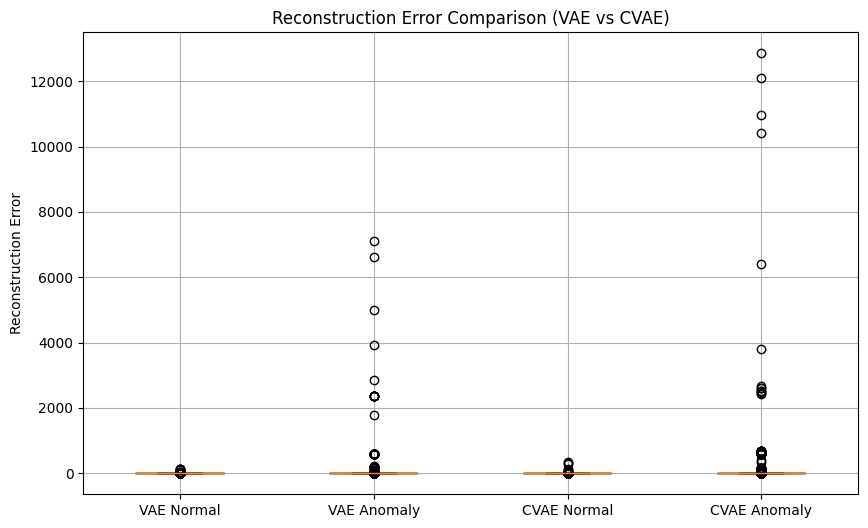

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# X_test에서 정상(Normal) 및 이상(Anomaly) 데이터 분리
X_test_normal = X_test[y_test == 0]
X_test_anomaly = X_test[y_test == 1]

# CVAE의 경우 레이블을 같이 입력해야 함
y_test_normal = y_test[y_test == 0]
y_test_anomaly = y_test[y_test == 1]

# 입력 차원 맞추기 (Conv1D 기반 CVAE라면 reshape 필요)
X_test_normal_cvae = np.expand_dims(X_test_normal, axis=-1)
X_test_anomaly_cvae = np.expand_dims(X_test_anomaly, axis=-1)

# 실제 모델에서 재구성 오류 계산
def compute_reconstruction_error(model, X, y=None):
    if y is not None:
        X_pred = model.predict([X, y])  # CVAE는 레이블도 입력
    else:
        X_pred = model.predict(X)  # VAE는 X만 입력

    # 차원 조정: (batch, features, 1) → (batch, features)
    X_pred = np.squeeze(X_pred, axis=-1) if X_pred.ndim == 3 else X_pred
    X = np.squeeze(X, axis=-1) if X.ndim == 3 else X
    
    return np.mean(np.square(X - X_pred), axis=1)  # MSE 계산

# 정상 데이터 및 이상 데이터에 대한 Reconstruction Error 계산
recon_error_vae_normal = compute_reconstruction_error(vae_model, X_test_normal)
recon_error_vae_anomaly = compute_reconstruction_error(vae_model, X_test_anomaly)

recon_error_cvae_normal = compute_reconstruction_error(cvae_model, X_test_normal_cvae, y_test_normal)
recon_error_cvae_anomaly = compute_reconstruction_error(cvae_model, X_test_anomaly_cvae, y_test_anomaly)

# Box Plot으로 비교
plt.figure(figsize=(10, 6))
plt.boxplot([
    recon_error_vae_normal, recon_error_vae_anomaly,
    recon_error_cvae_normal, recon_error_cvae_anomaly
], labels=["VAE Normal", "VAE Anomaly", "CVAE Normal", "CVAE Anomaly"])

plt.title("Reconstruction Error Comparison (VAE vs CVAE)")
plt.ylabel("Reconstruction Error")
plt.grid()
plt.show()


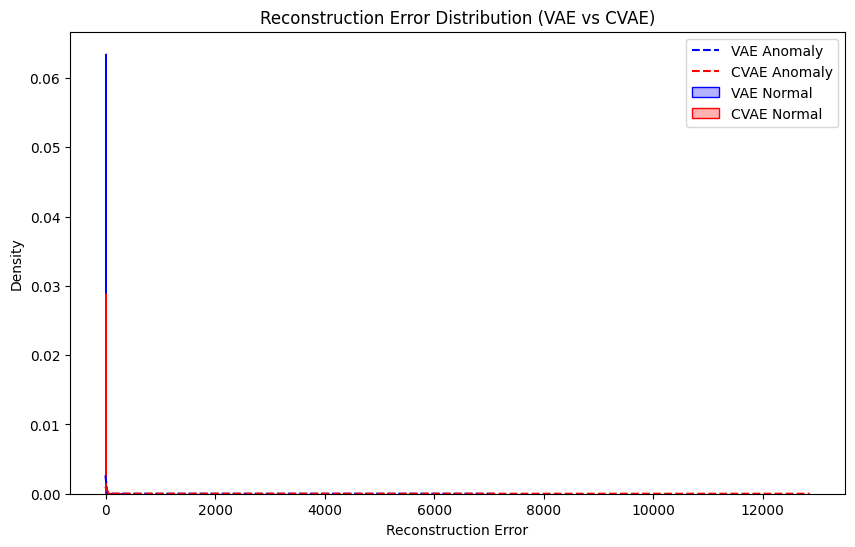

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.kdeplot(recon_error_vae_normal, label="VAE Normal", color='blue', fill=True, alpha=0.3)
sns.kdeplot(recon_error_vae_anomaly, label="VAE Anomaly", color='blue', linestyle="dashed")

sns.kdeplot(recon_error_cvae_normal, label="CVAE Normal", color='red', fill=True, alpha=0.3)
sns.kdeplot(recon_error_cvae_anomaly, label="CVAE Anomaly", color='red', linestyle="dashed")

plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.title("Reconstruction Error Distribution (VAE vs CVAE)")
plt.legend()
plt.show()


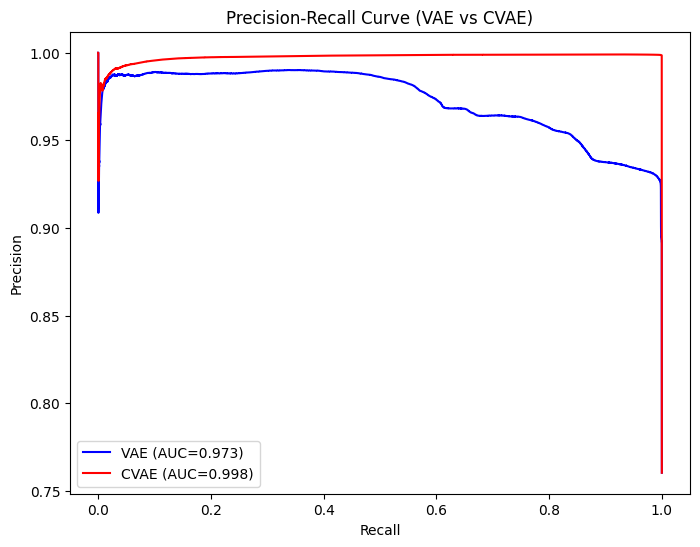

In [56]:
from sklearn.metrics import precision_recall_curve, auc

# 정상(Normal) 및 이상(Anomaly) 데이터 결합
X_test_combined = np.concatenate([X_test_normal, X_test_anomaly], axis=0)
y_true = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(X_test_anomaly))], axis=0)  # 정상=0, 이상=1

# VAE 및 CVAE의 재구성 오류 결합
vae_recon_error = np.concatenate([recon_error_vae_normal, recon_error_vae_anomaly], axis=0)
cvae_recon_error = np.concatenate([recon_error_cvae_normal, recon_error_cvae_anomaly], axis=0)

# Precision-Recall Curve 계산
precision_vae, recall_vae, _ = precision_recall_curve(y_true, vae_recon_error)
precision_cvae, recall_cvae, _ = precision_recall_curve(y_true, cvae_recon_error)

# AUC 계산
auc_vae = auc(recall_vae, precision_vae)
auc_cvae = auc(recall_cvae, precision_cvae)

# PR Curve 시각화
plt.figure(figsize=(8,6))
plt.plot(recall_vae, precision_vae, label=f'VAE (AUC={auc_vae:.3f})', color='blue')
plt.plot(recall_cvae, precision_cvae, label=f'CVAE (AUC={auc_cvae:.3f})', color='red')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (VAE vs CVAE)")
plt.legend()
plt.show()


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


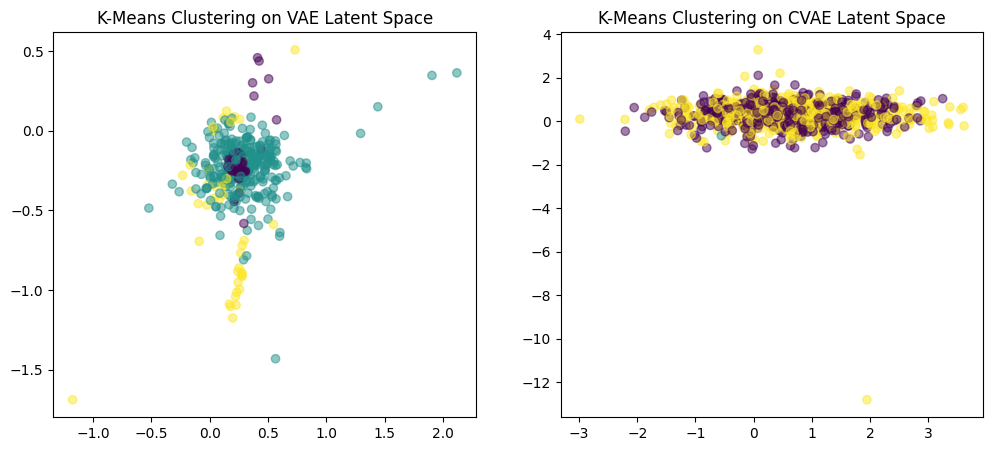

In [43]:
from sklearn.cluster import KMeans, DBSCAN

# K-Means 클러스터링
kmeans_vae = KMeans(n_clusters=3, random_state=42).fit(z_vae_sampled)
kmeans_cvae = KMeans(n_clusters=3, random_state=42).fit(z_cvae_sampled)

# DBSCAN 클러스터링
dbscan_vae = DBSCAN(eps=0.5, min_samples=5).fit(z_vae_sampled)
dbscan_cvae = DBSCAN(eps=0.5, min_samples=5).fit(z_cvae_sampled)

# 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(z_vae_sampled[:, 0], z_vae_sampled[:, 1], c=kmeans_vae.labels_, cmap="viridis", alpha=0.5)
plt.title("K-Means Clustering on VAE Latent Space")

plt.subplot(1, 2, 2)
plt.scatter(z_cvae_sampled[:, 0], z_cvae_sampled[:, 1], c=kmeans_cvae.labels_, cmap="viridis", alpha=0.5)
plt.title("K-Means Clustering on CVAE Latent Space")
plt.show()

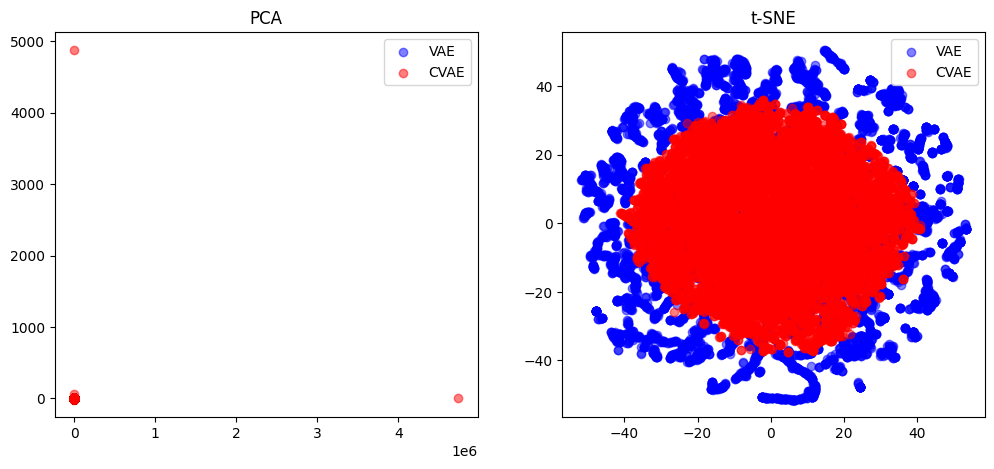

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 샘플링 (속도 개선)
num_samples = 10000
indices = np.random.choice(len(z_vae), num_samples, replace=False)
z_vae_sampled = z_vae[indices]
z_cvae_sampled = z_cvae[indices]

# PCA 변환
pca_vae = PCA(n_components=2).fit_transform(z_vae_sampled)
pca_cvae = PCA(n_components=2).fit_transform(z_cvae_sampled)

# t-SNE 변환
tsne_vae = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42).fit_transform(z_vae_sampled)
tsne_cvae = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42).fit_transform(z_cvae_sampled)

# 시각화 (UMAP 없이 PCA + t-SNE만 사용)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# PCA 시각화
axs[0].scatter(pca_vae[:, 0], pca_vae[:, 1], alpha=0.5, label="VAE", color='blue')
axs[0].scatter(pca_cvae[:, 0], pca_cvae[:, 1], alpha=0.5, label="CVAE", color='red')
axs[0].set_title("PCA")
axs[0].legend()

# t-SNE 시각화
axs[1].scatter(tsne_vae[:, 0], tsne_vae[:, 1], alpha=0.5, label="VAE", color='blue')
axs[1].scatter(tsne_cvae[:, 0], tsne_cvae[:, 1], alpha=0.5, label="CVAE", color='red')
axs[1].set_title("t-SNE")
axs[1].legend()

plt.show()


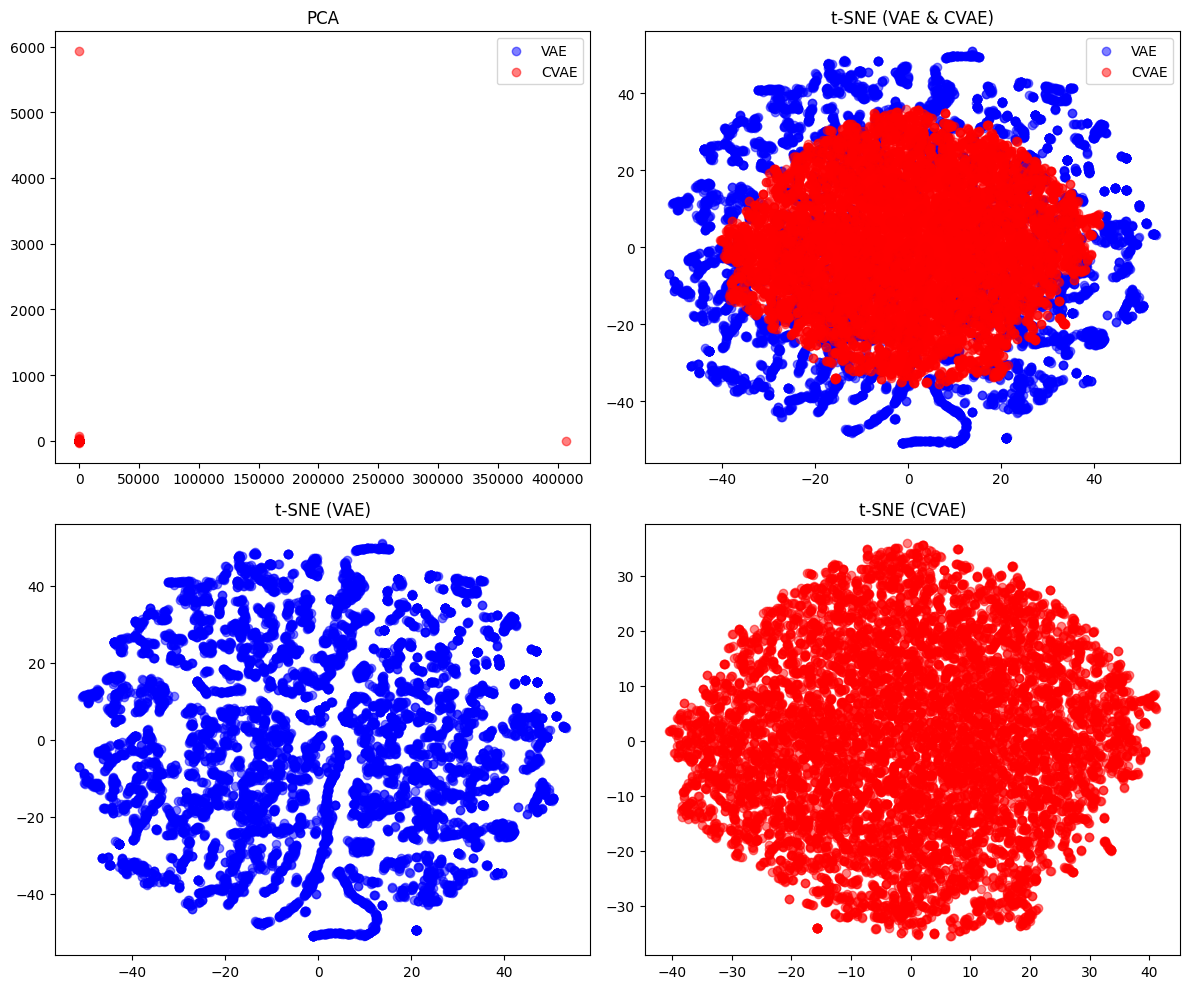

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 샘플링 (속도 개선)
num_samples = 10000
indices = np.random.choice(len(z_vae), num_samples, replace=False)
z_vae_sampled = z_vae[indices]
z_cvae_sampled = z_cvae[indices]

# PCA 변환
pca_vae = PCA(n_components=2).fit_transform(z_vae_sampled)
pca_cvae = PCA(n_components=2).fit_transform(z_cvae_sampled)

# t-SNE 변환
tsne_vae = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42).fit_transform(z_vae_sampled)
tsne_cvae = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42).fit_transform(z_cvae_sampled)

# 시각화 (UMAP 없이 PCA + t-SNE만 사용)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# PCA 시각화
axs[0, 0].scatter(pca_vae[:, 0], pca_vae[:, 1], alpha=0.5, label="VAE", color='blue')
axs[0, 0].scatter(pca_cvae[:, 0], pca_cvae[:, 1], alpha=0.5, label="CVAE", color='red')
axs[0, 0].set_title("PCA")
axs[0, 0].legend()

# t-SNE 시각화 (VAE + CVAE 같이 보여줌)
axs[0, 1].scatter(tsne_vae[:, 0], tsne_vae[:, 1], alpha=0.5, label="VAE", color='blue')
axs[0, 1].scatter(tsne_cvae[:, 0], tsne_cvae[:, 1], alpha=0.5, label="CVAE", color='red')
axs[0, 1].set_title("t-SNE (VAE & CVAE)")
axs[0, 1].legend()

# t-SNE VAE만 시각화
axs[1, 0].scatter(tsne_vae[:, 0], tsne_vae[:, 1], alpha=0.5, color='blue')
axs[1, 0].set_title("t-SNE (VAE)")

# t-SNE CVAE만 시각화
axs[1, 1].scatter(tsne_cvae[:, 0], tsne_cvae[:, 1], alpha=0.5, color='red')
axs[1, 1].set_title("t-SNE (CVAE)")

plt.tight_layout()
plt.show()


### 1. VAE (왼쪽)
덩어리처럼 군집된 부분이 존재하고, 빈 공간도 많음

이는 VAE가 입력 𝑥만 기반으로 z를 구성하다 보니,
클래스 정보 없이 자율적으로 패턴을 찾다가 특정 지역에 몰리게 된 결과일 수 있음.

결과적으로:
구조는 있어 보이지만, 클래스 구분이 명확하지 않을 수 있음
특히 이상 데이터가 끼어들면 재구성 에러가 낮아질 가능성 있음 → 탐지 실패 위험

### 2. CVAE (오른쪽)
데이터가 중앙 중심의 원형 구조로, 균일하고 치밀하게 분포

이는 CVAE가 입력뿐 아니라 라벨 y (정상)를 조건으로 학습했기 때문

→ z 공간을 𝑝(𝑧∣y=0)로 정렬함

그래서 "정상"이라는 조건 아래서 z가 특정 공간을 넓게, 고르게 채우도록 학습됨

결과적으로:

CVAE는 입력을 재구성할 때 “정상 조건”으로 잘 복원 가능

반대로 이상(anomaly)이 들어오면 z가 이 공간 밖으로 나가고 → reconstruction error가 커짐 → 탐지에 유리

The t-SNE visualization reveals that the latent space learned by the CVAE is significantly more uniform and dense compared to that of the VAE. While the VAE shows scattered clusters with uneven distribution, the CVAE's latent vectors form a well-structured and isotropic distribution. This indicates that the label conditioning in CVAE enables it to allocate the latent space more efficiently, leading to better reconstruction of normal data and higher sensitivity to anomalies outside the conditioned distribution.

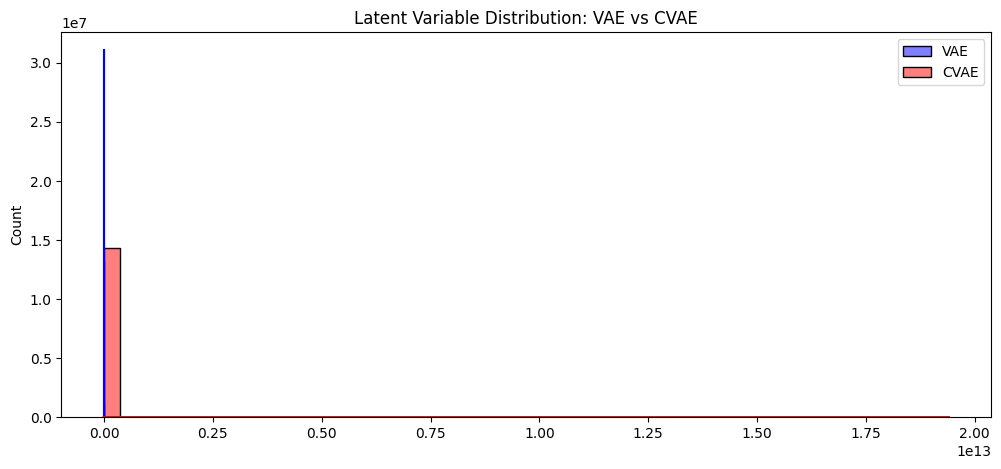

In [58]:
import seaborn as sns
plt.figure(figsize=(12,5))
sns.histplot(z_vae.flatten(), bins=50, color='blue', label='VAE', kde=True)
sns.histplot(z_cvae.flatten(), bins=50, color='red', label='CVAE', kde=True)
plt.legend()
plt.title("Latent Variable Distribution: VAE vs CVAE")
plt.show()


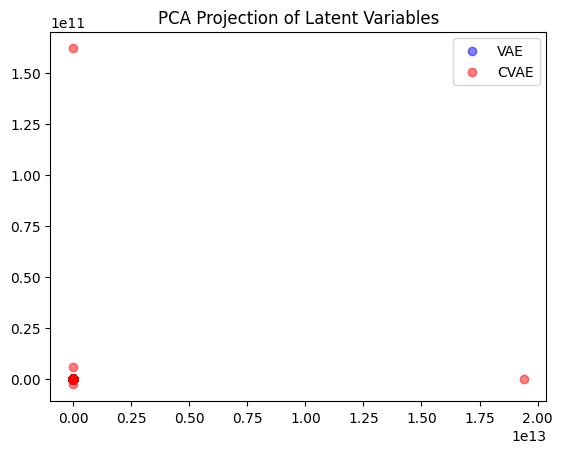

In [59]:
from sklearn.decomposition import PCA
z_vae_pca = PCA(n_components=2).fit_transform(z_vae)
z_cvae_pca = PCA(n_components=2).fit_transform(z_cvae)
plt.scatter(z_vae_pca[:,0], z_vae_pca[:,1], alpha=0.5, color='blue', label="VAE")
plt.scatter(z_cvae_pca[:,0], z_cvae_pca[:,1], alpha=0.5, color='red', label="CVAE")
plt.legend()
plt.title("PCA Projection of Latent Variables")
plt.show()


In [60]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# K-Means를 전체 데이터에 맞춰 다시 훈련
num_clusters = 2  # 클러스터 개수는 실험에 맞게 설정
kmeans_vae = KMeans(n_clusters=num_clusters, random_state=42).fit(z_vae)
kmeans_cvae = KMeans(n_clusters=num_clusters, random_state=42).fit(z_cvae)

# Silhouette Score 계산
silhouette_vae = silhouette_score(z_vae, kmeans_vae.labels_)
silhouette_cvae = silhouette_score(z_cvae, kmeans_cvae.labels_)

print(f"VAE Silhouette Score: {silhouette_vae:.4f}")
print(f"CVAE Silhouette Score: {silhouette_cvae:.4f}")


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


VAE Silhouette Score: 0.6131
CVAE Silhouette Score: 1.0000


In [61]:
num_samples = 1000
indices = np.random.choice(len(z_vae), num_samples, replace=False)
z_vae_sampled = z_vae[indices]
z_cvae_sampled = z_cvae[indices]

# K-Means를 샘플링된 데이터에 적용
kmeans_vae = KMeans(n_clusters=2, random_state=42).fit(z_vae_sampled)
kmeans_cvae = KMeans(n_clusters=2, random_state=42).fit(z_cvae_sampled)

# Silhouette Score 계산
silhouette_vae = silhouette_score(z_vae_sampled, kmeans_vae.labels_)
silhouette_cvae = silhouette_score(z_cvae_sampled, kmeans_cvae.labels_)


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
for num_clusters in [2, 3, 5, 10]:
    kmeans_vae = KMeans(n_clusters=num_clusters, random_state=42).fit(z_vae)
    kmeans_cvae = KMeans(n_clusters=num_clusters, random_state=42).fit(z_cvae)
    score_vae = silhouette_score(z_vae, kmeans_vae.labels_)
    score_cvae = silhouette_score(z_cvae, kmeans_cvae.labels_)
    print(f"Clusters: {num_clusters} | VAE: {score_vae:.4f} | CVAE: {score_cvae:.4f}")


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clusters: 2 | VAE: 0.6131 | CVAE: 1.0000


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clusters: 3 | VAE: 0.6405 | CVAE: 1.0000


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Clusters: 5 | VAE: 0.6109 | CVAE: 1.0000


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


59062/59062 [==============================] - 57s 968us/step


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\numpy\lib\nanfunctions.py:1550: RuntimeWarning: overflow encountered in multiply
  out=None,


VAE MI 평균: 0.2667
CVAE MI 평균: 0.0049


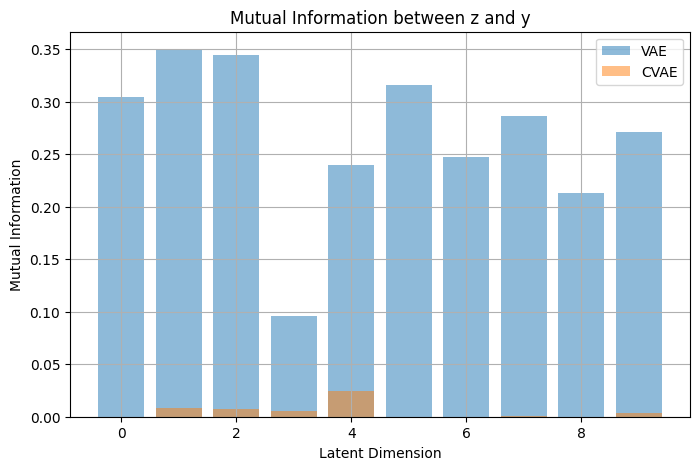

In [94]:
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

# z 재추출 (VAE)
z_mean_vae, z_log_sigma_vae = encoder_vae.predict(X_train)
z_vae_full = sampling(z_mean_vae, z_log_sigma_vae).numpy()

# z 재추출 (CVAE)
z_mean_cvae, z_log_sigma_cvae = encoder_cvae.predict([X_train, y_train])
z_cvae_full = sampling(z_mean_cvae, z_log_sigma_cvae).numpy()

# 이상값 정제 (NaN, inf, 너무 큰 값 방지)
z_vae_full = np.nan_to_num(z_vae_full, nan=0.0, posinf=1e6, neginf=-1e6)
z_cvae_full = np.nan_to_num(z_cvae_full, nan=0.0, posinf=1e6, neginf=-1e6)

# Mutual Information 계산
mi_vae = mutual_info_regression(z_vae_full, y_train)
mi_cvae = mutual_info_regression(z_cvae_full, y_train)

# 평균 Mutual Information 출력
print(f"VAE MI 평균: {np.mean(mi_vae):.4f}")
print(f"CVAE MI 평균: {np.mean(mi_cvae):.4f}")

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(range(len(mi_vae)), mi_vae, alpha=0.5, label="VAE")
plt.bar(range(len(mi_cvae)), mi_cvae, alpha=0.5, label="CVAE")
plt.xlabel("Latent Dimension")
plt.ylabel("Mutual Information")
plt.title("Mutual Information between z and y")
plt.legend()
plt.grid()
plt.show()


In [95]:
#  z → y 분류 정확도 (Latent 벡터만으로 y 예측 가능성)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(max_iter=200)

# Classification accuracy
score_vae = cross_val_score(clf, z_vae_full, y_train, cv=5).mean()
score_cvae = cross_val_score(clf, z_cvae_full, y_train, cv=5).mean()

print(f" z → y Accuracy | VAE: {score_vae:.4f} | CVAE: {score_cvae:.4f}")




C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

 z → y Accuracy | VAE: 0.9593 | CVAE: 0.7594


C:\Users\gnssl\anaconda3\envs\myvenv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mutual Information 해석
VAE는 z와 y 사이의 MI가 높다 → latent vector z가 라벨 정보를 많이 담고 있음.

CVAE는 MI가 거의 없음 → z는 라벨 정보와 독립적.

왜 이런 일이 벌어졌을까?
CVAE는 본질적으로 조건부 모델이기 때문에: 𝑝(𝑧∣𝑥,𝑦)을 통해 z를 생성하고, decoder는𝑝(𝑥∣𝑧,𝑦)을 학습함
즉, 라벨 정보는 decoder로 직접 전달되기 때문에, 굳이 z 안에 y 정보를 담을 필요가 없음.

Classification Accuracy 해석
VAE의 z는 라벨 분류에 매우 적합 (95.9%)

CVAE의 z는 라벨 분류가 어려움 (75.9%)

결론:
VAE는 z가 자동으로 y에 따라 정렬됨 → 라벨이 없어도 z가 정보를 담으려 함.

CVAE는 라벨이 decoder에 직접 전달되기 때문에, z는 다른 latent 구조(예: residual noise, 스타일 정보)를 표현.

Despite CVAE being a conditional model trained with label information, the latent representation 𝑧 becomes conditionally independent from 𝑦, as evidenced by significantly lower mutual information and classification accuracy compared to the VAE. This behavior aligns with the theoretical understanding of CVAE, where label information is explicitly provided to the decoder, thereby reducing the need for the latent space to encode class-discriminative features.


 z → y Accuracy | VAE: 0.9593 | CVAE: 0.7594



In [96]:
# VAE Reconstruction Error
errors_vae = compute_reconstruction_error(vae_model, X_test)
results_vae = evaluate_ids_performance(y_test, errors_vae)

# CVAE Reconstruction Error
errors_cvae = compute_reconstruction_error(cvae_model, X_test, y_test)
results_cvae = evaluate_ids_performance(y_test, errors_cvae)

# 결과 출력
print("VAE IDS Performance:", results_vae)
print("CVAE IDS Performance:", results_cvae)


20771/20771 [==============================] - 34s 2ms/step
VAE IDS Performance: {'threshold': 0.002092436307558856, 'AUC': 0.9392173986074952, 'Precision': 0.9304258051050396, 'Recall': 0.9878163389265795, 'F1 Score': 0.9582625585631235, 'Confusion Matrix': array([[121893,  37334],
       [  6158, 499273]], dtype=int64)}
CVAE IDS Performance: {'threshold': 0.3649280227580235, 'AUC': 0.9977982086720649, 'Precision': 0.9985121840860997, 'Recall': 0.9998555688115688, 'F1 Score': 0.9991834249096924, 'Confusion Matrix': array([[158474,    753],
       [    73, 505358]], dtype=int64)}
